# Task 8.3 Load ZTM Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import cm
import networkx as nx
import re
import pandas as pd

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection

## Link to parser, made available for other students: https://github.com/wojtas000/SNARS-ZTMParser

In [2]:
class ZTMParser:

    def __init__(self, file_path):
        '''
        Initializes the object by reading the .TXT file and extracting the relevant information about ZTM communication architecture.
        '''

        with open(file_path, 'r') as file:
            self.content = file.read()
            self.station_groups = self.extract_station_groups()
            self.stations = self.extract_stations()
            self.transport_lines = self.extract_transport_lines()
            self.transport_lines_variants = self.extract_transport_line_numbers_and_types()

    def extract_station_groups(self):
        '''
        Extracts station groups from the file.
        Returns: pandas dataframe with columns: ID, Name, City Code, City Name
        '''

        match = re.search(r'\*ZA (\d+)(.*?)#ZA', self.content, re.DOTALL)
        num_records = int(match.group(1))
        section_content = match.group(2).strip().split('\n')

        # Initialize lists to store data
        ids, names, city_codes, city_names = [], [], [], []

        # Extract information from each line in the section
        for line in section_content:
            # delete spaces at the beginning and end of the line
            line = line.strip()
            parts = re.split(r'\s{3,}|,\s*|\s{2,}', line, maxsplit=3)
            if len(parts) >= 4:
                ids.append(parts[0])
                names.append(parts[1])
                city_codes.append(parts[2])
                city_names.append(parts[3])

        # Create a pandas dataframe
        data = {'ID': ids, 'Name': names, 'City Code': city_codes, 'City Name': city_names}
        df = pd.DataFrame(data)

        return df
    
    def extract_stations(self):
        '''
        Extracts stations from the file 
        Returns: pandas dataframe with columns: Group_ID, ID, Street, Destination, Y and X coordinates.
        '''

        data = []
        zp_match = re.search(r'\*ZP (\d+)(.*?)#ZP', self.content, re.DOTALL)
        zp_section_content = zp_match.group(2).strip().split('\n')

        for line in zp_section_content:
            # if stripped line starts with 6 digit ID
            if re.match(r'\d{6}', line.strip()):
                # split line when there are 3 or more spaces
                parts = re.split(r'\s{3,}', line.strip(), maxsplit=6)
                group_id = parts[0][:-2]
                id = parts[0]
                street = parts[2].replace('Ul./Pl.: ', '').strip()
                destination = parts[3].replace('Kier.: ', '').strip()
                y_coord = re.search(r'(\d+(\.\d*)?)', parts[4]).group(1) if re.search(r'(\d+(\.\d*)?)', parts[4]) else None
                x_coord = re.search(r'(\d+(\.\d*)?)', parts[5]).group(1) if re.search(r'(\d+(\.\d*)?)', parts[5]) else None
                data.append({'Group_ID': group_id, 'ID': id, 'Street': street, 'Destination': destination, 'Y': y_coord, 'X': x_coord})
            else:
                continue

        df = pd.DataFrame(data)
        return df
    
    def extract_transport_lines(self):
        '''
        Extracts bus lines from the file and returns a dictionary of pandas dataframes.
        Each dataframe represents a single bus line and is indexed by station number in correct order.

        Returns: dictionary of pandas dataframes with columns: ID, Name
        '''
        ll_match = re.search(r'\*LL (\d+)(.*?)#LL', self.content, re.DOTALL)
        ll_section_content = ll_match.group(2).strip().split('\n')

        bus_lines_dict = {}

        lw_matches = re.findall(r'\*LW(.*?)#LW', ll_match.group(2), re.DOTALL)
        for i, lw_section in enumerate(lw_matches):
            station_ids = []
            station_name = []
            for line in lw_section.split('\n'):
                match = re.search(r'r (\d{6})\s+(.+?),\s*--', line)
                if match:
                    station_ids.append(match.group(1))
                    station_name.append(match.group(2).strip())
            
            bus_lines_dict[i] = pd.DataFrame({'ID': station_ids, 'Name': station_name}, index=range(1, len(station_ids)+1))
          
        return bus_lines_dict

    def extract_transport_line_numbers_and_types(self):
        '''
        Extracts info about transport lines from the file and returns a pandas dataframe.
        Each row represents a single transport line (or its variant) and contains information about line number, variant number and type (BUS, TRAM, TRAIN).
        '''

        ll_match = re.search(r'\*LL (\d+)(.*?)#LL', self.content, re.DOTALL)
        ll_section_content = ll_match.group(2).strip().split('\n')
        line_names = []
        variants = []

        for line, next_line in zip(ll_section_content, ll_section_content[1:]):
            # get lines with beginning Linia: string
            if re.match(r'Linia:', line.strip()):
                
                line_name = line.strip()
                next_line = next_line.strip()
                number_of_variants = re.search(r'(\d+)', next_line).group(1)
                line_names += [line_name] * int(number_of_variants)
                variants += list(range(1, int(number_of_variants)+1))

        df = pd.DataFrame({ 'Line Name': line_names, 'Variant': variants})

        df['Line Number'] = df['Line Name'].apply(lambda x: '-'.join(x.split('-')[:-1]).strip())
        df['Line Name'] = df['Line Name'].apply(lambda x: x.split('-')[-1].strip())
        bus = ['LINIA ZWYKŁA', 'LINIA ZWYKŁA OKRESOWA', 'LINIA EKSPRESOWA', 'LINIA PRZYSPIESZONA', 'LINIA PRZYSPIESZONA OKRESOWA', 'LINIA STREFOWA', 'LINIA STREFOWA UZUPEŁNIAJĄCA', 'LINIA STREFOWA UZUPEŁNIAJĄCA', 'LINIA NOCNA', 'LINIA ZASTĘPCZA', 'LINIA SPECJALNA']
        tram = ['LINIA TRAMWAJOWA', 'LINIA TRAMWAJOWA UZUPEŁNIAJĄCA']
        train = ['LINIA KOLEI MIEJSKIEJ']
        df['Line Type'] = df['Line Name'].apply(lambda x: 'BUS' if x in bus else 'TRAM' if x in tram else 'TRAIN' if x in train else None)
        # drop Line Name column
        df.drop('Line Name', axis=1, inplace=True)

        return df

    def get_edges(self, layer=None):
        '''
        Returns a list of tuples representing edges of the graph.
        Each tuple contains two station IDs. If layer is specified, only edges of that layer are returned. Accepted layer values: BUS, TRAM, TRAIN.
        '''
        layer_lines = self.transport_lines_variants[self.transport_lines_variants['Line Type'] == layer].index
        edges  = []
        iterator = layer_lines if layer else self.transport_lines.keys()
        for line in iterator:
            line = self.transport_lines[line]
            for i in range(len(line)-1):
                edges.append((line.iloc[i]['ID'], line.iloc[i+1]['ID']))
        return edges
    
    def get_nodes(self):
        '''
        Returns a list of station IDs.
        '''

        return list(self.stations['ID'])
    
    def get_coordinates(self):
        '''
        Returns a dictionary of tuples representing coordinates of each station.
        '''

        # Convert 'X' and 'Y' columns to numeric values
        self.stations['X'] = pd.to_numeric(self.stations['X'], errors='coerce')
        self.stations['Y'] = pd.to_numeric(self.stations['Y'], errors='coerce')

        return dict(zip(self.stations['ID'], zip(self.stations['X'], self.stations['Y'])))


In [3]:
file_path = 'RA230105.TXT' 
ztm = ZTMParser(file_path)

edges = ztm.get_edges()

# Plot network layers

In [4]:
edges_bus = ztm.get_edges(layer='BUS')
edges_tram = ztm.get_edges(layer='TRAM')
edges_train = ztm.get_edges(layer='TRAIN')

### implementation of LayeredNetworkGraph from https://stackoverflow.com/questions/60392940/multi-layer-graph-in-networkx

In [312]:
class LayeredNetworkGraph(object):

    def __init__(self, graphs, node_labels=None, layout=nx.spring_layout, ax=None):
        """Given an ordered list of graphs [g1, g2, ..., gn] that represent
        different layers in a multi-layer network, plot the network in
        3D with the different layers separated along the z-axis.

        Within a layer, the corresponding graph defines the connectivity.
        Between layers, nodes in subsequent layers are connected if
        they have the same node ID.

        Arguments:
        ----------
        graphs : list of networkx.Graph objects
            List of graphs, one for each layer.

        node_labels : dict node ID : str label or None (default None)
            Dictionary mapping nodes to labels.
            If None is provided, nodes are not labelled.

        layout_func : function handle (default networkx.spring_layout)
            Function used to compute the layout.

        ax : mpl_toolkits.mplot3d.Axes3d instance or None (default None)
            The axis to plot to. If None is given, a new figure and a new axis are created.

        """

        # book-keeping
        self.graphs = graphs
        self.total_layers = len(graphs)

        self.node_labels = node_labels
        self.layout = layout

        if ax:
            self.ax = ax
        else:
            fig = plt.figure()
            self.ax = fig.add_subplot(111, projection='3d')

        # create internal representation of nodes and edges
        self.get_nodes()
        self.get_edges_within_layers()
        self.get_edges_between_layers()

        # compute layout and plot
        self.get_node_positions()
        self.draw()


    def get_nodes(self):
        """Construct an internal representation of nodes with the format (node ID, layer)."""
        self.nodes = []
        for z, g in enumerate(self.graphs):
            self.nodes.extend([(node, z) for node in g.nodes()])


    def get_edges_within_layers(self):
        """Remap edges in the individual layers to the internal representations of the node IDs."""
        self.edges_within_layers = []
        for z, g in enumerate(self.graphs):
            self.edges_within_layers.extend([((source, z), (target, z)) for source, target in g.edges()])


    def get_edges_between_layers(self):
        """Determine edges between layers. Nodes in subsequent layers are
        thought to be connected if they have the same ID."""
        self.edges_between_layers = []
        for z1, g in enumerate(self.graphs[:-1]):
            z2 = z1 + 1
            h = self.graphs[z2]
            shared_nodes = set(g.nodes()) & set(h.nodes())
            self.edges_between_layers.extend([((node, z1), (node, z2)) for node in shared_nodes])


    def get_node_positions(self, *args, **kwargs):
        """Get the node positions in the layered layout."""
        # What we would like to do, is apply the layout function to a combined, layered network.
        # However, networkx layout functions are not implemented for the multi-dimensional case.
        # Futhermore, even if there was such a layout function, there probably would be no straightforward way to
        # specify the planarity requirement for nodes within a layer.
        # Therefor, we compute the layout for the full network in 2D, and then apply the
        # positions to the nodes in all planes.
        # For a force-directed layout, this will approximately do the right thing.
        # TODO: implement FR in 3D with layer constraints.

        composition = self.graphs[0]
        for h in self.graphs[1:]:
            composition = nx.compose(composition, h)

        pos = nx.spring_layout(composition, k=0.02)

        self.node_positions = dict()
        for z, g in enumerate(self.graphs):
            self.node_positions.update({(node, z) : (*pos[node], z) for node in g.nodes()})


    def draw_nodes(self, nodes, *args, **kwargs):
        x, y, z = zip(*[self.node_positions[node] for node in nodes])
        self.ax.scatter(x, y, z, *args, **kwargs)


    def draw_edges(self, edges, *args, **kwargs):
        segments = [(self.node_positions[source], self.node_positions[target]) for source, target in edges]
        line_collection = Line3DCollection(segments, *args, **kwargs)
        self.ax.add_collection3d(line_collection)


    def get_extent(self, pad=0.1):
        xyz = np.array(list(self.node_positions.values()))
        xmin, ymin, _ = np.min(xyz, axis=0)
        xmax, ymax, _ = np.max(xyz, axis=0)
        dx = xmax - xmin
        dy = ymax - ymin
        return (xmin - pad * dx, xmax + pad * dx), \
            (ymin - pad * dy, ymax + pad * dy)


    def draw_plane(self, z, *args, **kwargs):
        (xmin, xmax), (ymin, ymax) = self.get_extent(pad=0.1)
        u = np.linspace(xmin, xmax, 10)
        v = np.linspace(ymin, ymax, 10)
        U, V = np.meshgrid(u ,v)
        W = z * np.ones_like(U)
        self.ax.plot_surface(U, V, W, *args, **kwargs)


    def draw_node_labels(self, node_labels, *args, **kwargs):
        for node, z in self.nodes:
            if node in node_labels:
                ax.text(*self.node_positions[(node, z)], node_labels[node], *args, **kwargs)


    def draw(self):

        self.draw_edges(self.edges_within_layers,  color='k', alpha=0.3, linestyle='-', zorder=2, linewidths=0.5)
        self.draw_edges(self.edges_between_layers, color='k', alpha=0.3, linestyle='--', zorder=2)

        for z in range(self.total_layers):
            self.draw_plane(z, alpha=0.2, zorder=1)
            self.draw_nodes([node for node in self.nodes if node[1]==z], s=30, zorder=3)

        if self.node_labels:
            self.draw_node_labels(self.node_labels,
                                  horizontalalignment='center',
                                  verticalalignment='center',
                                  zorder=100)
    
    def draw_legend(self):
        legend_elements = []

        for z, graph in enumerate(self.graphs):
            legend_elements.append(plt.Line2D([0], [0], linestyle='-', color='k', alpha=0.3, label=f'{graph.name} (Layer {z + 1})'))

        self.ax.legend(handles=legend_elements, loc='upper right')



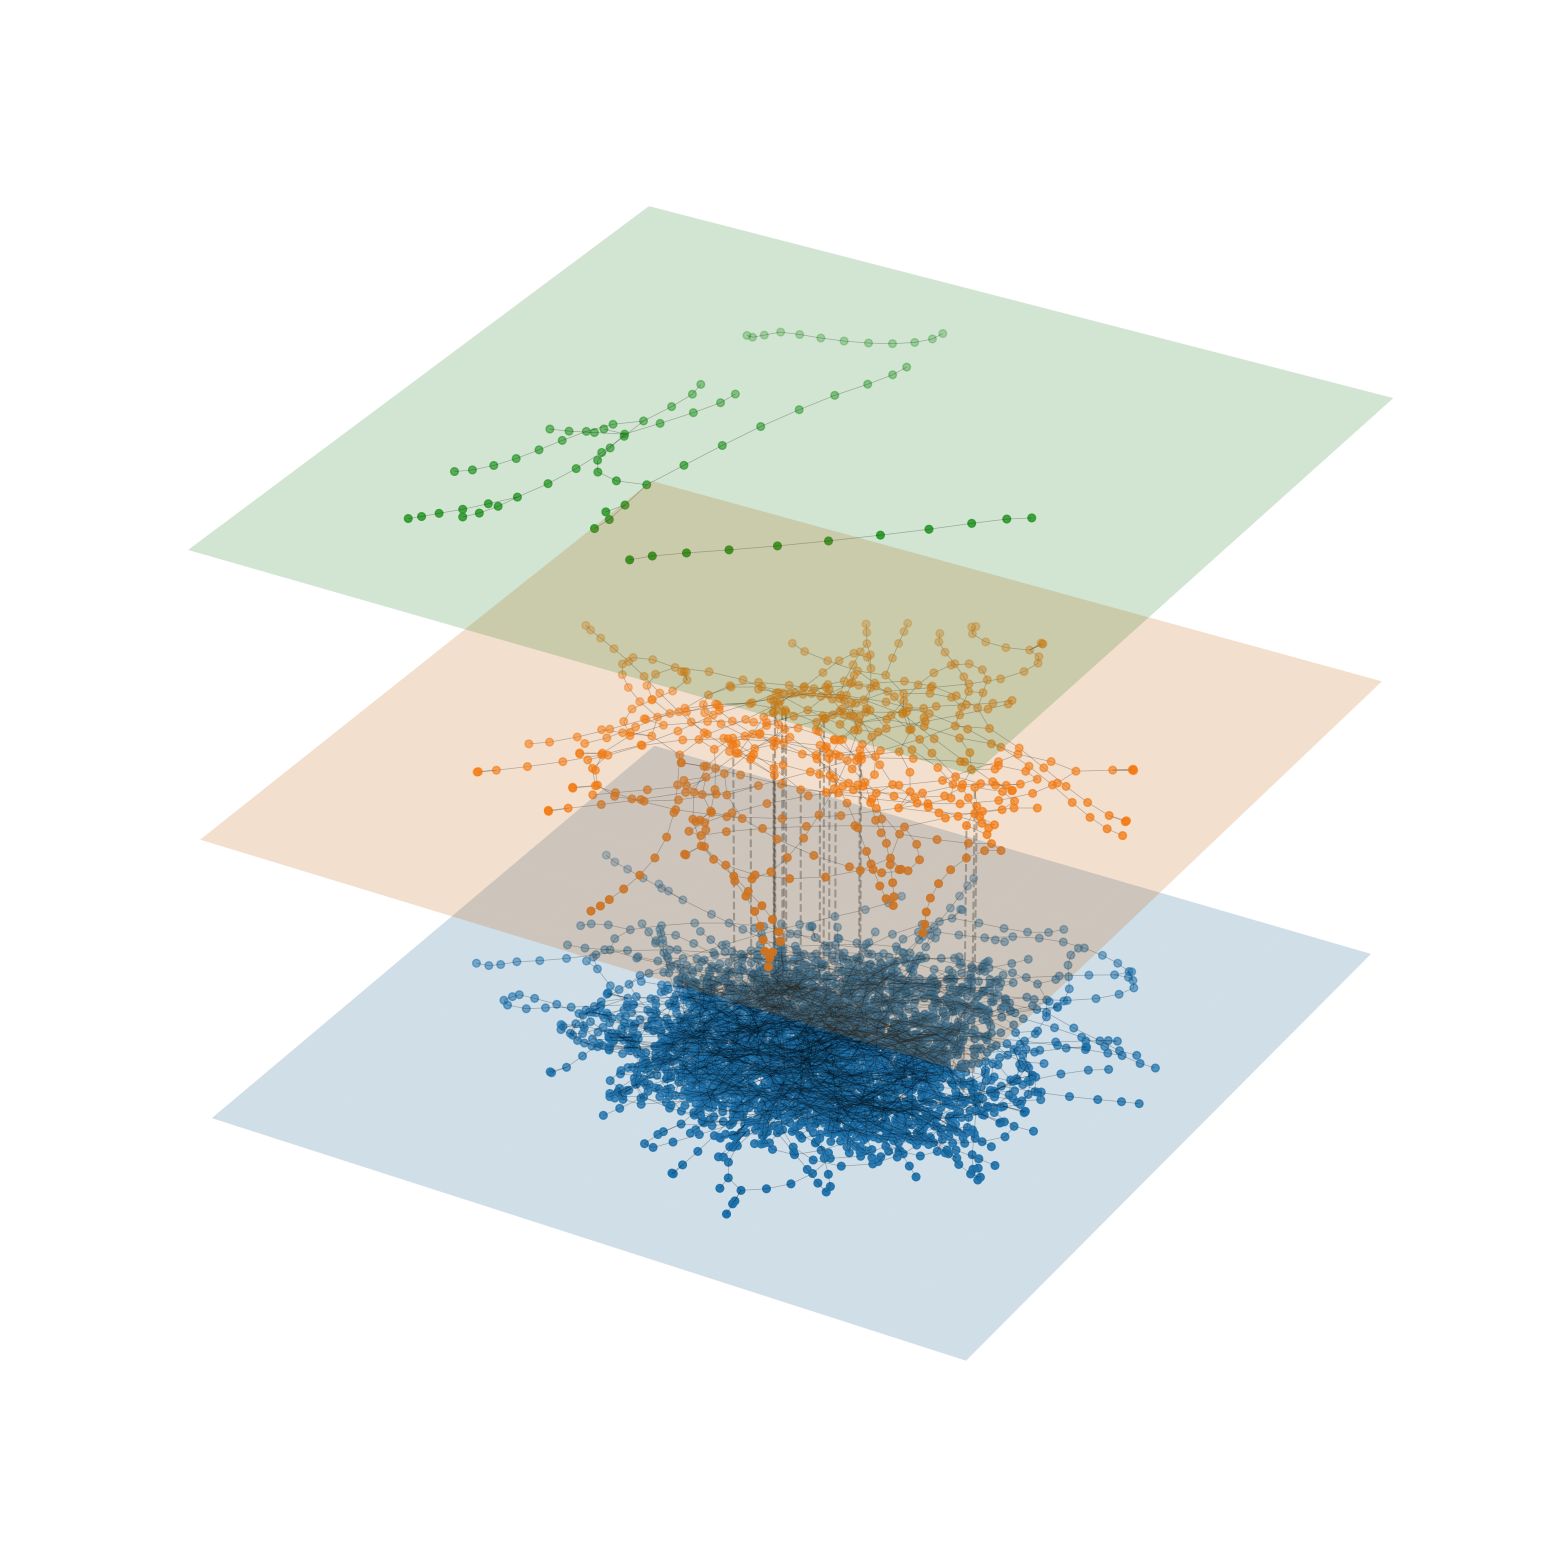

In [314]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')
layered_graph = LayeredNetworkGraph([bus, tram, train], ax=ax, node_labels=None)
ax.set_axis_off()
plt.show()

# Task 8.4

In [315]:
from scipy.stats import pearsonr
import powerlaw 

In [329]:
# Calculate basic graph properties
def calculate_basic_graph_characteristics(graph):
    # 1. Node number
    num_nodes = graph.number_of_nodes()
    
    # 2. Edge number
    num_edges = graph.number_of_edges()
    
    # 3. Average degree
    avg_degree = np.mean(list(dict(graph.degree()).values()))
    
    # 4. Power law parameter alpha of network
    degrees = [degree for node, degree in graph.degree()]
    fit = powerlaw.Fit(degrees, discrete=True)
    alpha = fit.alpha
    
    # 5. Correlation coefficient of network
    correlation_coefficient = nx.degree_pearson_correlation_coefficient(graph)
    
    # 6. Clustering coefficient of network
    # clustering_coefficient = nx.average_clustering(graph)
    
    #7. Average shortest path length
    if nx.is_connected(graph):
        avg_shortest_path_length = nx.average_shortest_path_length(graph)
    else:   
        # calculate for largest connected component
        largest_cc = max(nx.connected_components(graph), key=len)
        avg_shortest_path_length = nx.average_shortest_path_length(graph.subgraph(largest_cc))

    
    # Create a Pandas DataFrame
    data = {
        'Node Number': [num_nodes],
        'Edge Number': [num_edges],
        'Average Degree': [avg_degree],
        'Power Law Alpha': [alpha],
        # 'Clustering Coefficient': [clustering_coefficient],
        'Correlation Coefficient': [correlation_coefficient],
        'Average Shortest Path Length': [avg_shortest_path_length]
    }
    df = pd.DataFrame(data)
    return df

In [330]:
bus = nx.MultiGraph()
bus.add_edges_from(edges_bus)
tram = nx.MultiGraph()
tram.add_edges_from(edges_tram)
train = nx.MultiGraph()
train.add_edges_from(edges_train)
full = nx.MultiGraph()
full.add_edges_from(edges)

bus.name = 'Bus'
tram.name = 'Tram'
train.name = 'Train'
full.name = 'Full'

In [350]:
# plot histogram of degrees
def plot_degree_histogram(graph, ax):
    degrees = [degree for node, degree in graph.degree()]
    ax.hist(degrees, bins=15)
    ax.set_xlabel('Degree')
    ax.set_ylabel('Number of nodes')
    ax.set_title(f'Degree histogram ({graph.name})')
    ax.grid(axis='y', alpha=0.75)

# When considering multi-graph

In [331]:
bus_stats = calculate_basic_graph_characteristics(bus)
tram_stats = calculate_basic_graph_characteristics(tram)
train_stats = calculate_basic_graph_characteristics(train)
full_stats = calculate_basic_graph_characteristics(full)
# Create a Pandas DataFrame
df = pd.concat([bus_stats, tram_stats, train_stats, full_stats])
df.index = ['Bus', 'Tram', 'Train', 'Full']
df

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


,Node Number,Edge Number,Average Degree,Power Law Alpha,Correlation Coefficient,Average Shortest Path Length
Bus,3620,15517,8.572928,5.724411,0.631047,20.469573
Tram,535,1694,6.332710,4.882991,0.681256,19.111400
Train,74,99,2.675676,7.019224,0.495478,6.553846
Full,4212,17424,8.273504,5.806839,0.649814,21.535945


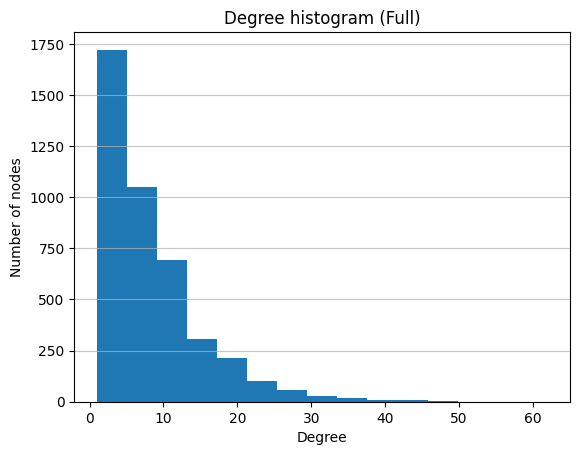

In [351]:
plot_degree_histogram(full, ax = plt.subplot(1, 1, 1))

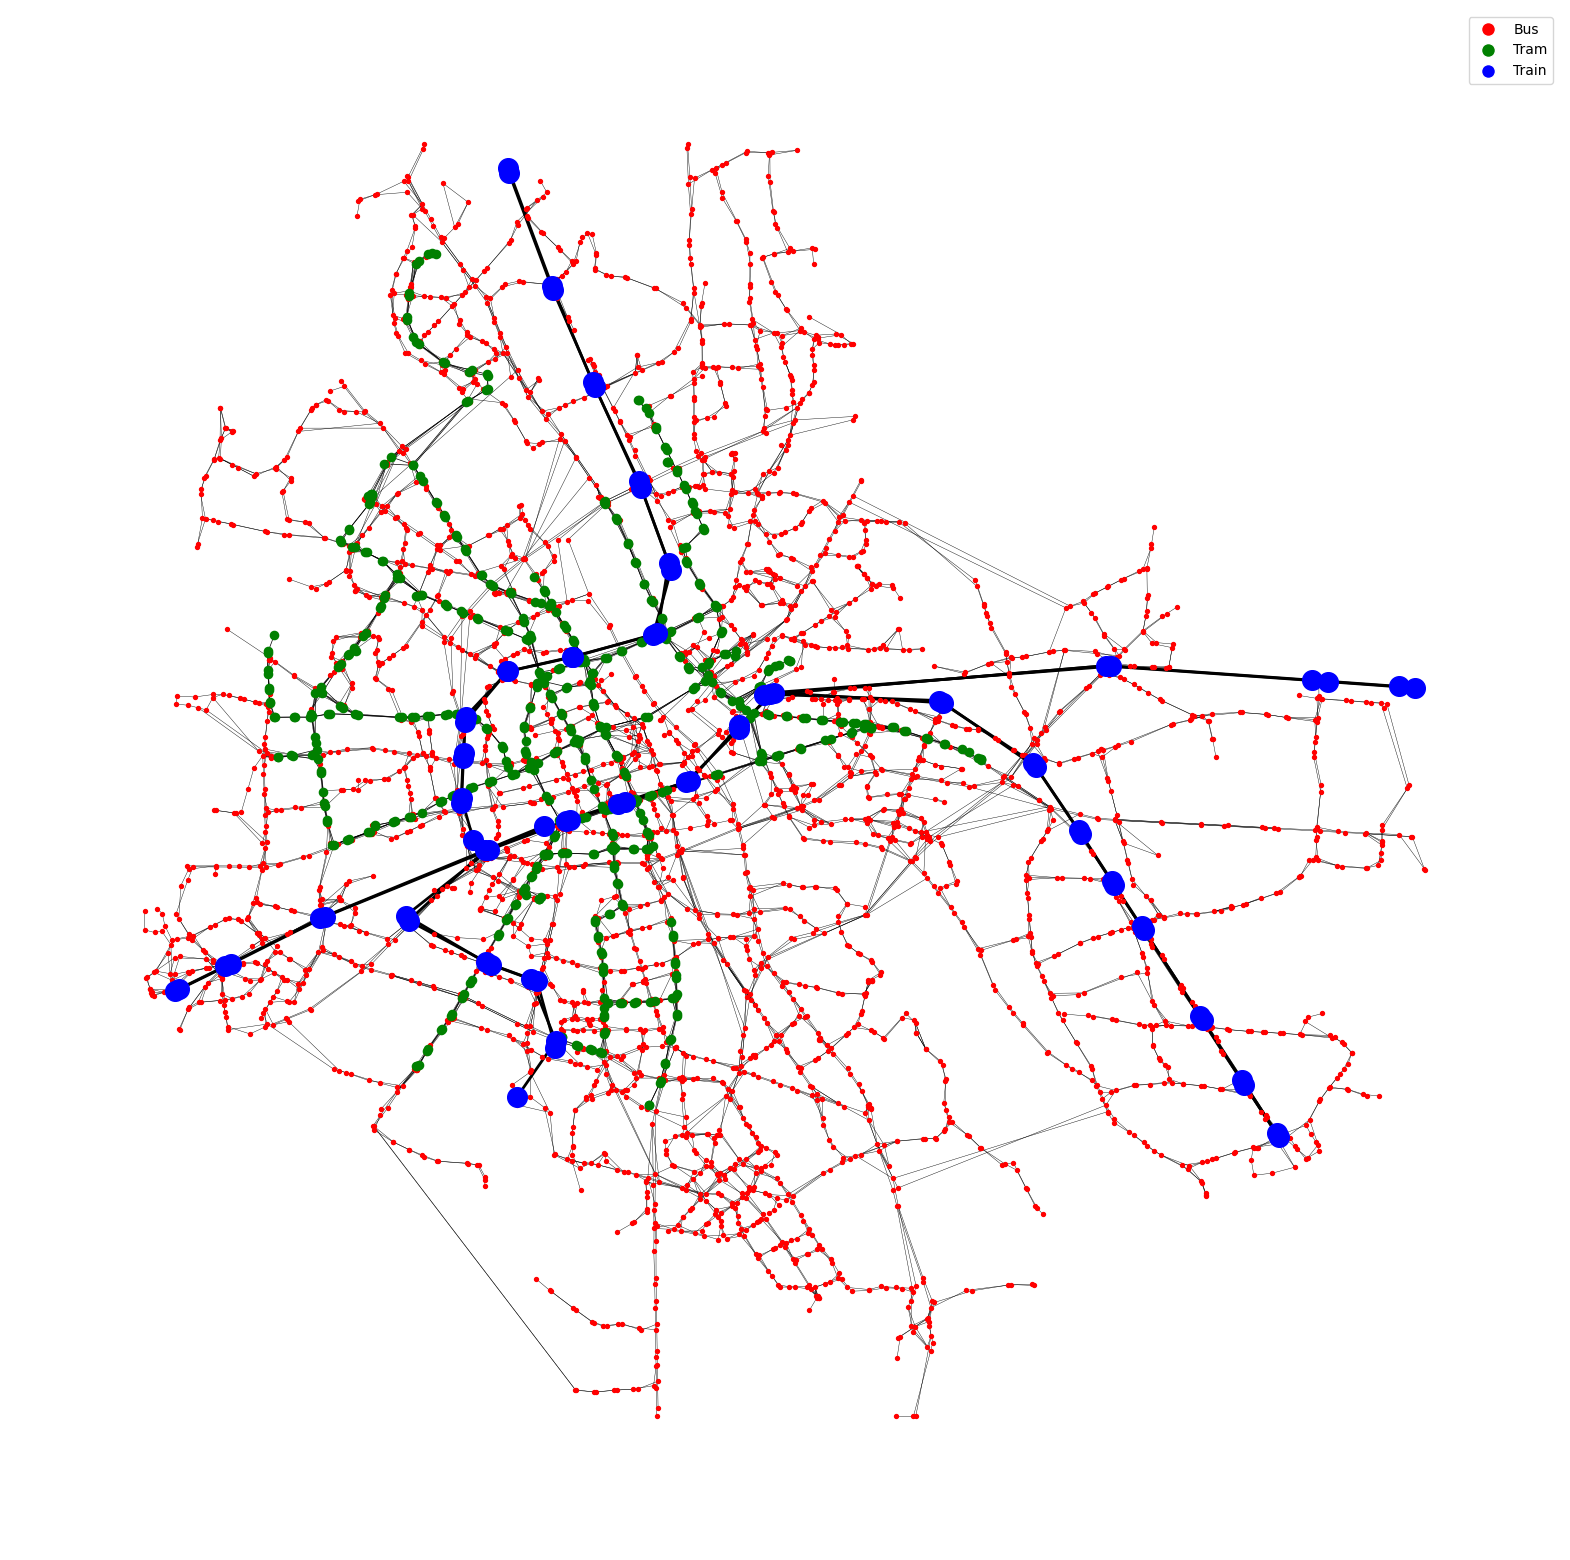

In [302]:
fig = plt.figure(figsize=(20, 20))

bus_graph = nx.Graph()
bus_graph.add_edges_from(edges_bus)

tram_graph = nx.Graph()
tram_graph.add_edges_from(edges_tram)

train_graph = nx.Graph()
train_graph.add_edges_from(edges_train)

pos = ztm.get_coordinates()

# Plot each layer separately
legend_elements = []
for graph, color, label, node_size, width in zip(
        [bus_graph, tram_graph, train_graph],
        ['red', 'green', 'blue'],
        ['Bus', 'Tram', 'Train'],
        [8, 35, 200],  # Adjust node sizes
        [0.3, 0.5, 2.0],  # Adjust line widths
):
    nx.draw(graph, pos, node_size=node_size, node_color=color, width=width, ax=fig.gca(), label=label)
    legend_elements.append(Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10))

# Add legend
fig.gca().legend(handles=legend_elements)

plt.show()


# Graph in proper configuration (with regard to GPS coordinates)

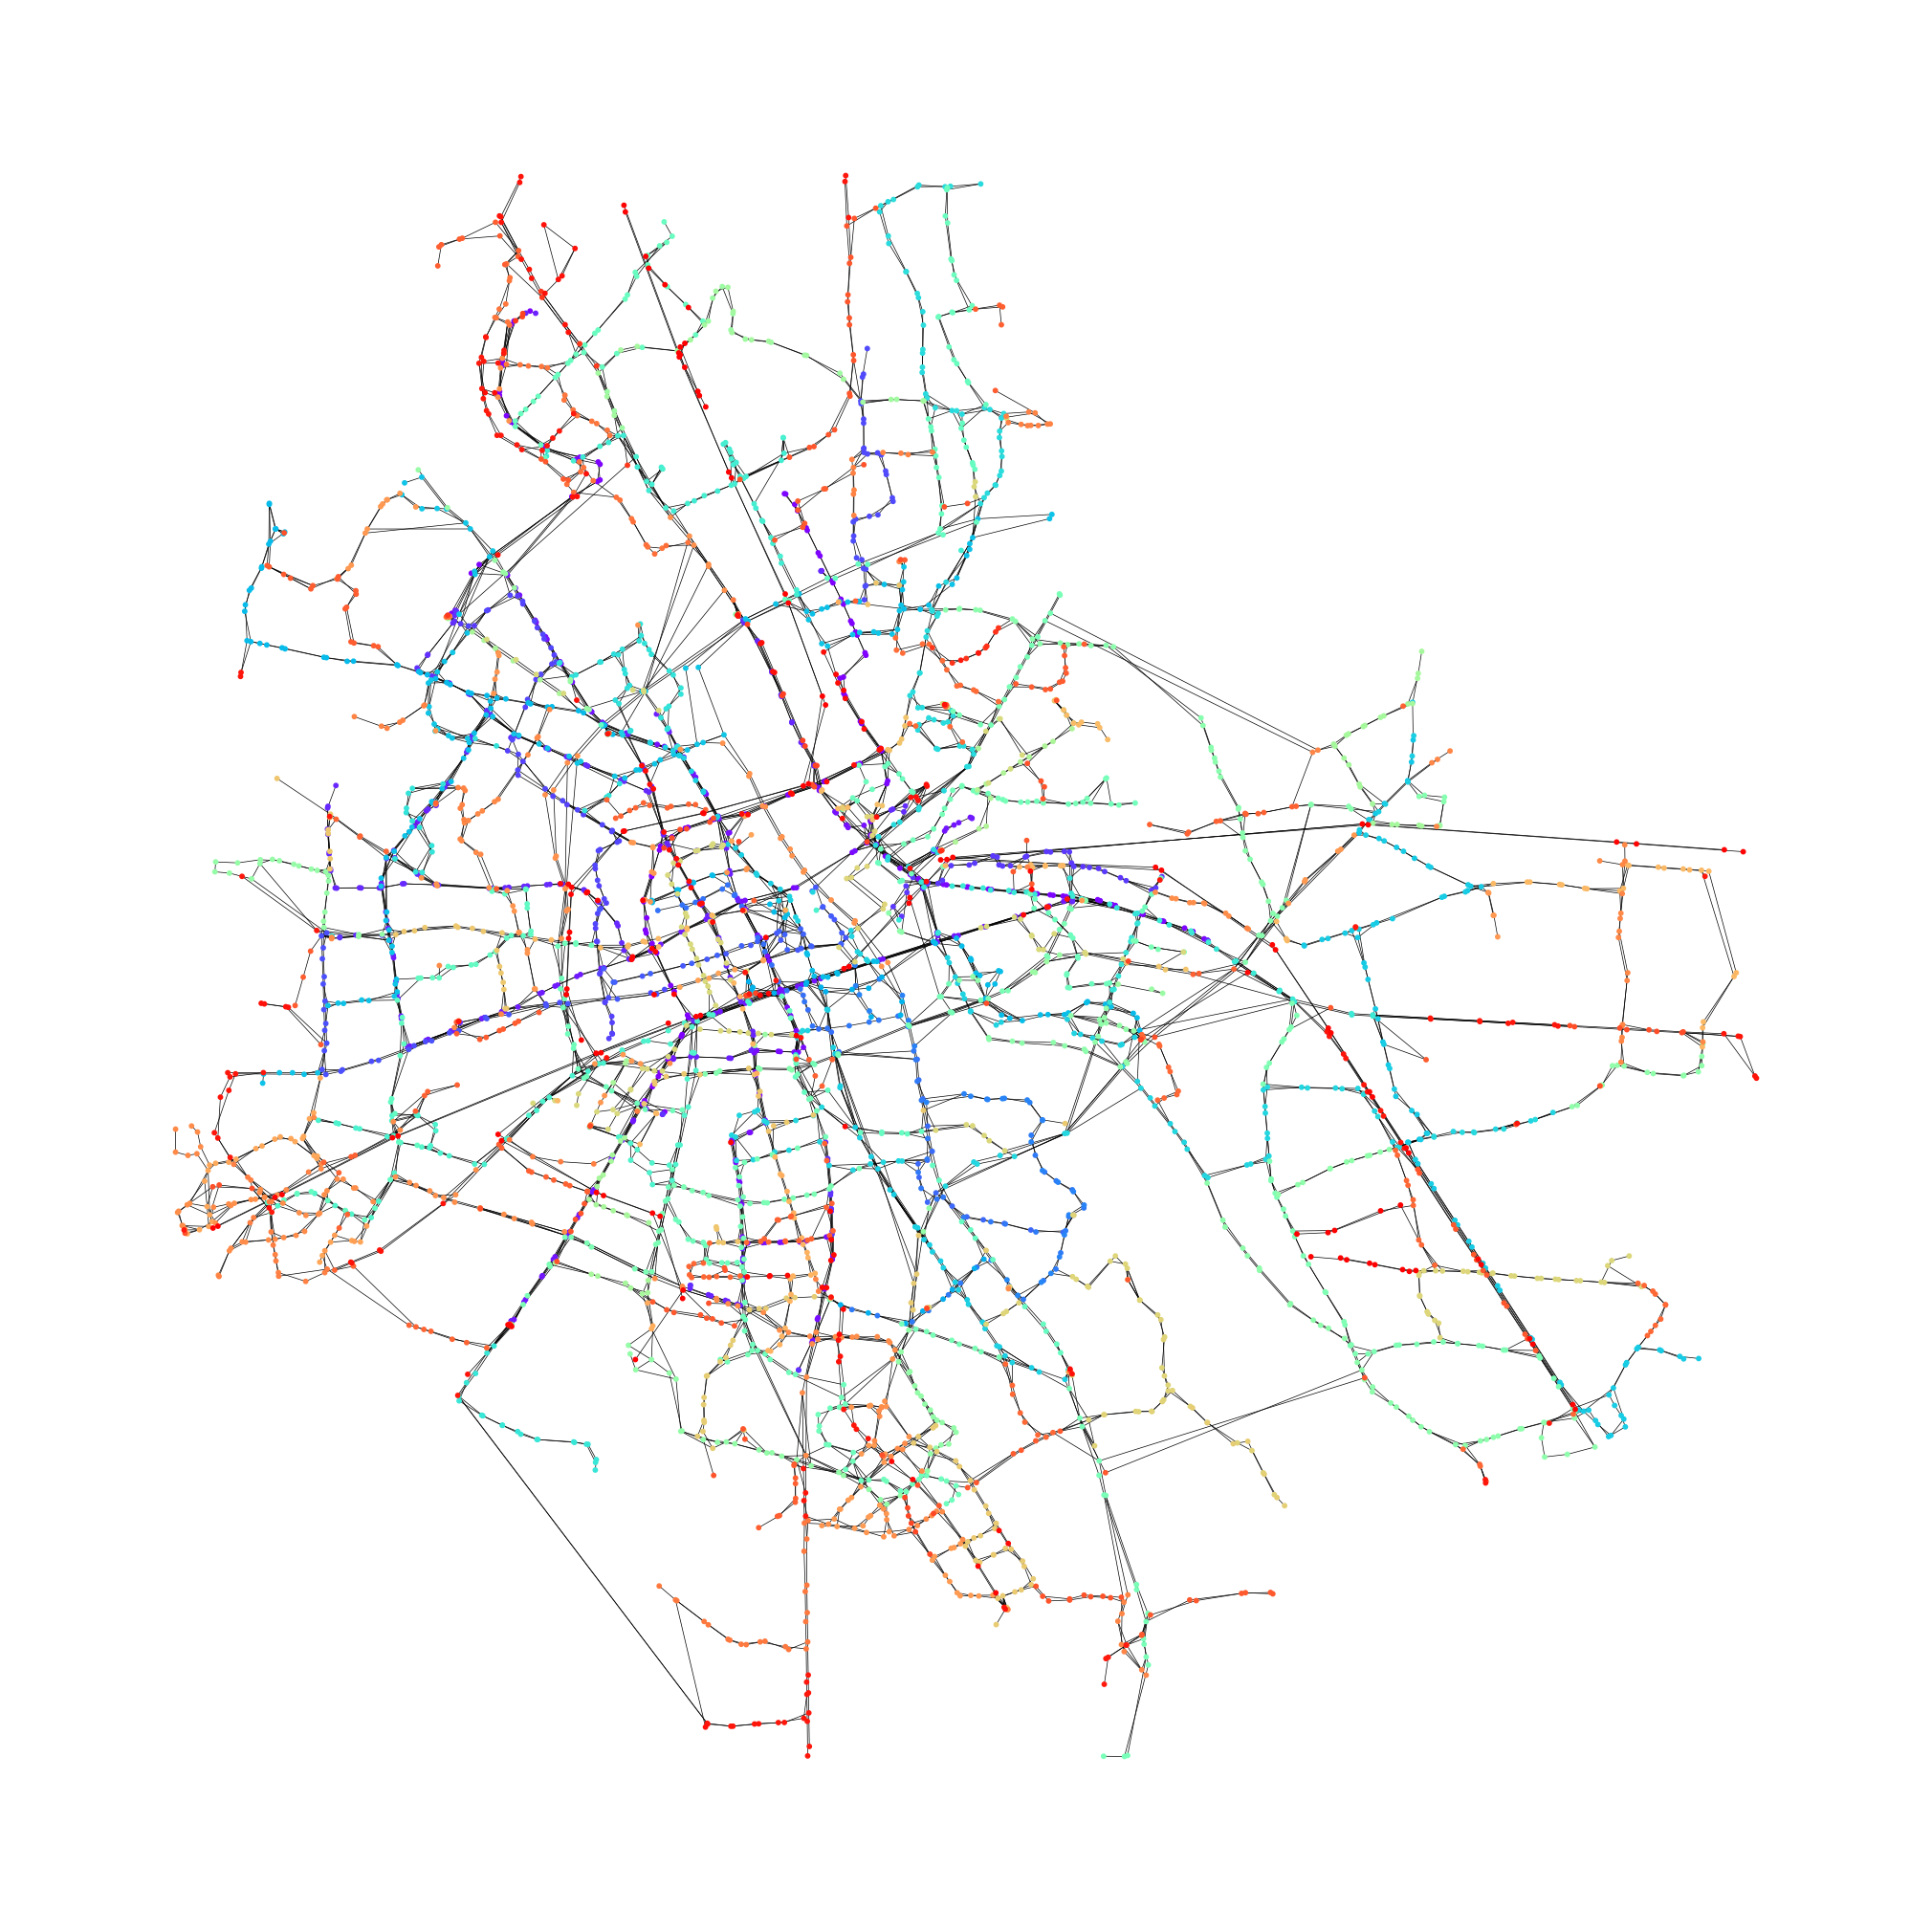

In [281]:
fig = plt.figure(figsize=(20, 20))

G = nx.Graph()
G.add_edges_from(edges)
pos = ztm.get_coordinates()
group_ids = ztm.stations['Group_ID'].unique()

# set different color for each station group
colors = cm.rainbow(np.linspace(0, 1, len(group_ids)))
# create a dictionary with group_id as key and color as value
color_dict = dict(zip(group_ids, colors))
# get nodes which appear in G
stations = ztm.stations[ztm.stations['ID'].isin(G.nodes())]

node_colors = stations['Group_ID'].apply(lambda x: color_dict[x])

nx.draw(G, pos, node_size=10, node_color=node_colors, width=0.5)
plt.show()


# Project 9

# P9.1 - na kartce

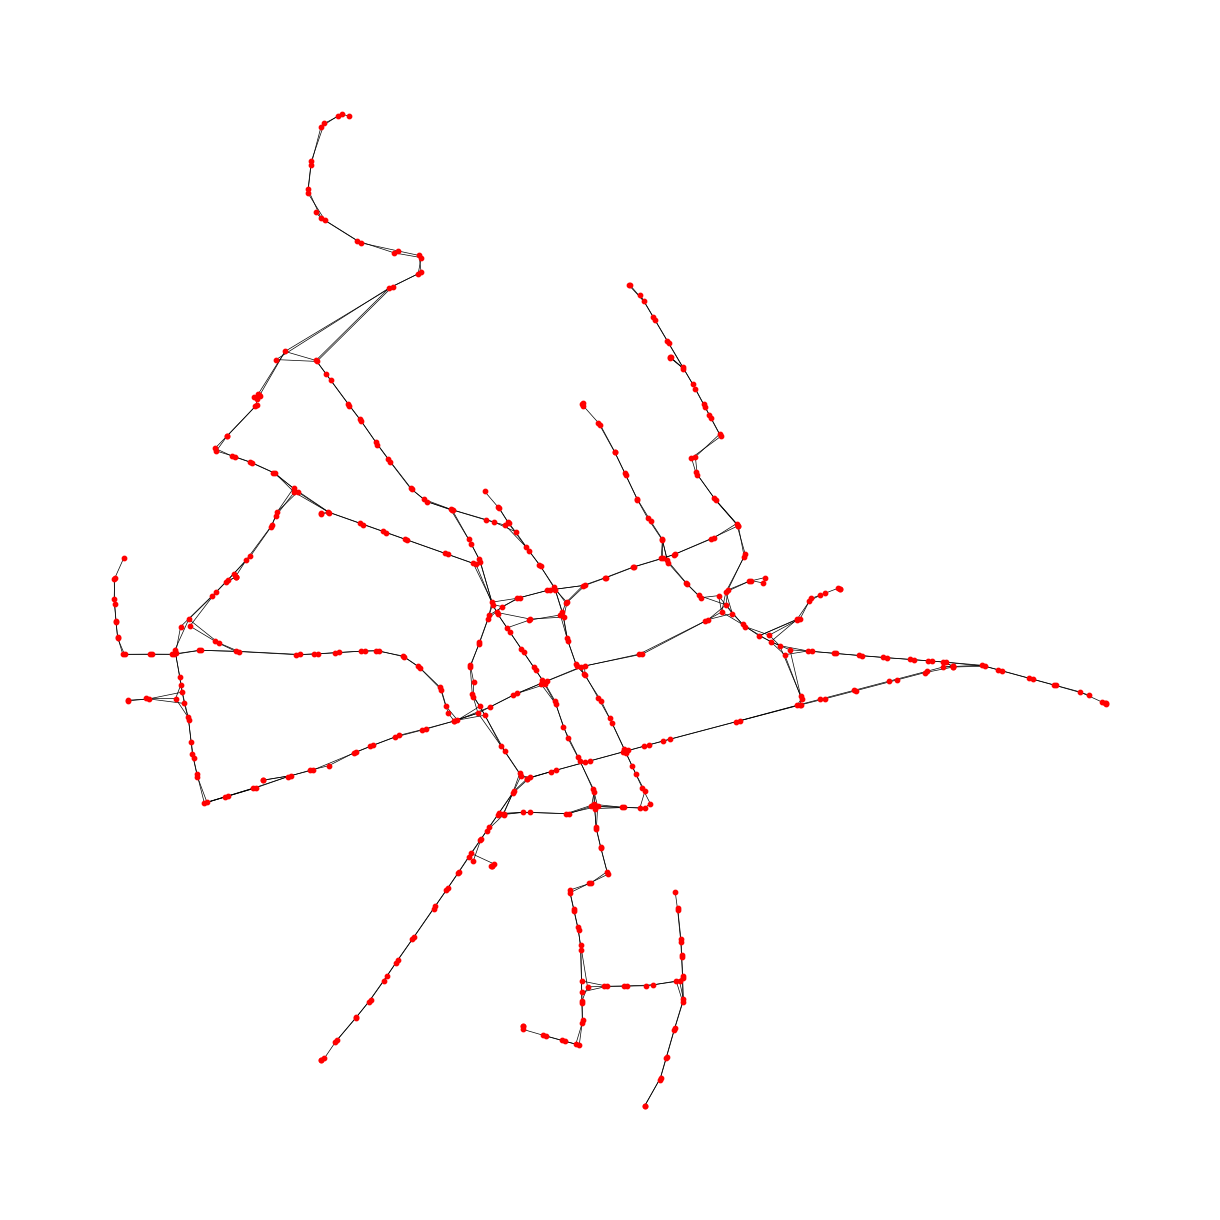

In [4]:
fig = plt.figure(figsize=(12, 12))

G = nx.Graph()
edges = ztm.get_edges(layer='TRAM')
G.add_edges_from(edges)
pos = ztm.get_coordinates()
# get only pos for nodes which appear in G
pos = {node: pos[node] for node in G.nodes()}

stations = ztm.stations[ztm.stations['ID'].isin(G.nodes())]


nx.draw(G, pos, node_size=10, node_color='red', width=0.5, font_size=8)
plt.show()


In [5]:
nx.is_connected(G)
# G finite and connected, so we can get the ergodic distribution


True

In [14]:
import numpy as np

def get_transition_matrix(G):
    
    nodes = list(G.nodes())
    transition_matrix = np.zeros((len(nodes), len(nodes)))
    edges = list(G.edges())
    # fill matrix
    for edge in edges:
        source = edge[0]
        target = edge[1]
        source_index = nodes.index(source)
        target_index = nodes.index(target)
        transition_matrix[source_index][target_index] += 1
        transition_matrix[target_index][source_index] += 1
    # normalize matrix
    transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)
    return transition_matrix

# get transition matrix for graph G
A = get_transition_matrix(G)

# P9.3

In [8]:
# simulate random walk

def simulate_random_walk(transition_matrix, steps=10000):
    # get number of nodes
    num_nodes = transition_matrix.shape[0]
    # create empty list to store visited nodes
    visited_nodes = np.zeros(num_nodes, dtype=int)
    # get starting node
    starting_node = np.random.randint(0, num_nodes)
    # add starting node to visited nodes
    visited_nodes[starting_node] = 1
    # get starting node distribution
    distribution = transition_matrix[starting_node]
    # simulate random walk
    for i in range(steps):
        # get next node
        next_node = np.random.choice(num_nodes, p=distribution)
        # add next node to visited nodes
        visited_nodes[next_node] += 1
        # update distribution
        distribution = transition_matrix[next_node]
        
    return np.array(visited_nodes) / steps

In [11]:
ergodic_distribution_simulation = simulate_random_walk(A, steps = 10000)

# P9.2

In [15]:
# Compute the eigenvectors and eigenvalues of the transpose of A
eigenvalues, eigenvectors = np.linalg.eig(A.T)

# Find the eigenvector corresponding to eigenvalue 1
ergodic_distribution_numeric = np.real_if_close(eigenvectors[:, np.isclose(eigenvalues, 1)])

# Normalize the stationary distribution
ergodic_distribution_numeric = ergodic_distribution_numeric / ergodic_distribution_numeric.sum()


# Comparison of numeric and dynamic ergodic density

In [13]:
print(np.linalg.norm(ergodic_distribution_numeric - ergodic_distribution_simulation))

0.48344272810828437


In [11]:
print(np.linalg.norm(ergodic_distribution_numeric - ergodic_distribution_simulation, ord=1))

1.420340000000002


# P9.5

In [14]:
from networkx import pagerank

pageranks = pagerank(G, alpha=0.85)


# BUS line with node size corresponding to pagerank value

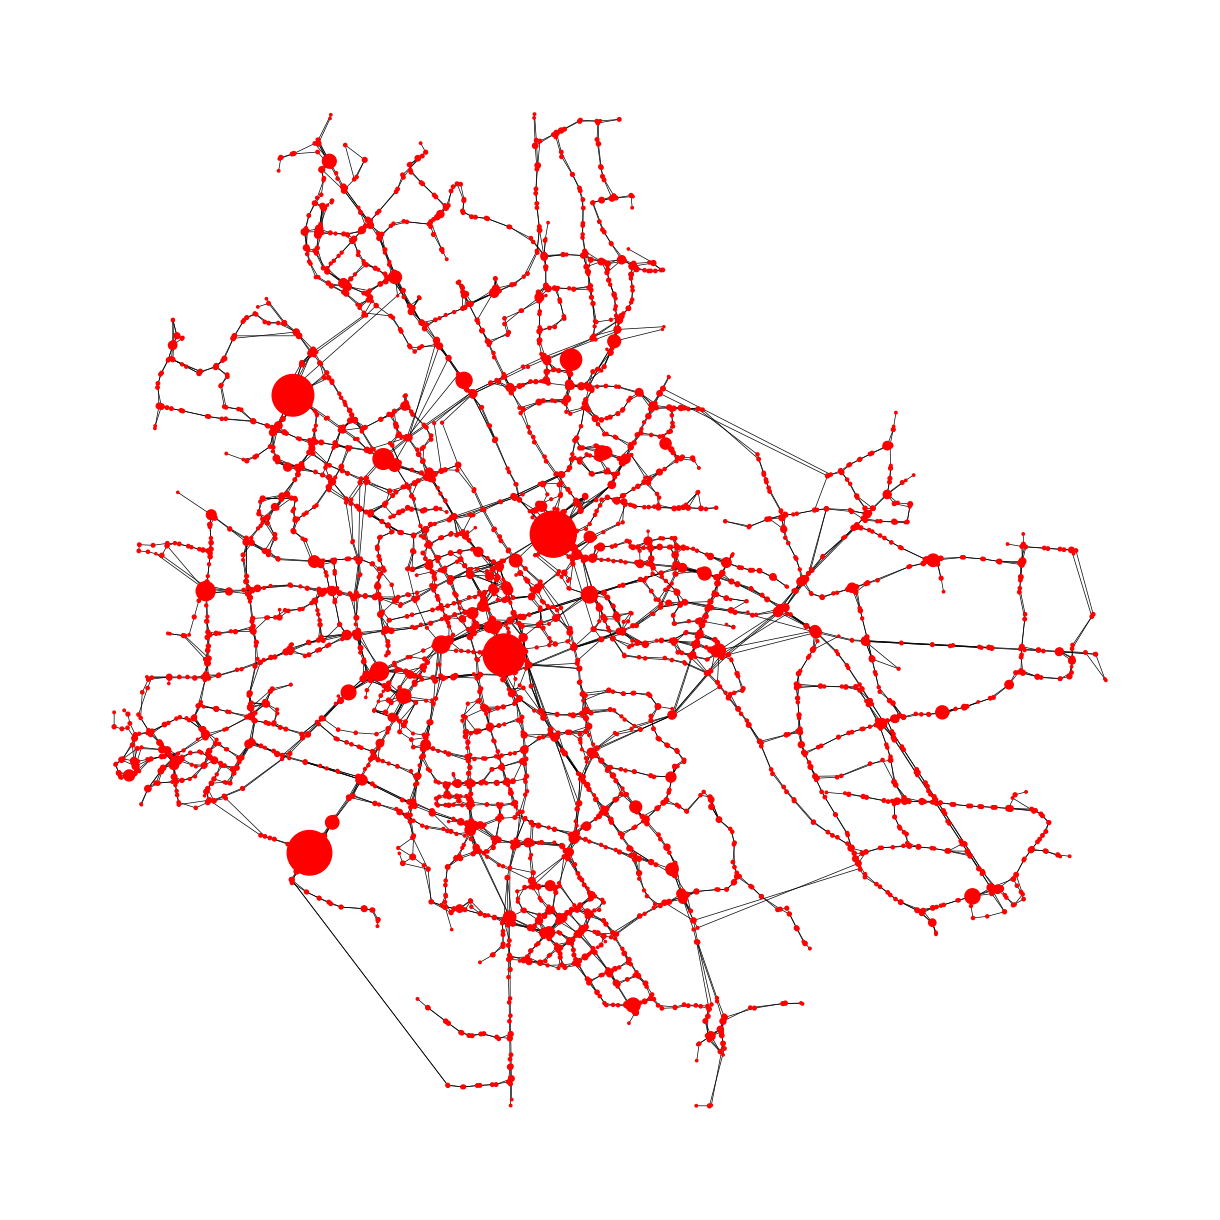

In [17]:
# plot graph with pagerank as node size
fig = plt.figure(figsize=(12, 12))

G = nx.Graph()
edges = ztm.get_edges(layer='BUS')
G.add_edges_from(edges)
pos = ztm.get_coordinates()
pageranks = pagerank(G, alpha=0.85)
# get only pos for nodes which appear in G
pos = {node: pos[node] for node in G.nodes()}
# get nodes which appear in G
stations = ztm.stations[ztm.stations['ID'].isin(G.nodes())]

# get pagerank values
pagerank_values = [pageranks[node] for node in G.nodes()]
pagerank_values = np.array([value / max(pagerank_values) * 7 for value in pagerank_values])
# log scale of pagerank values
pagerank_values = np.exp(pagerank_values)


nx.draw(G, pos, node_size=pagerank_values, node_color='red', width=0.5, font_size=8)